In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import scipy
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('punkt')
nltk.download('stopwords')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package punkt to /Users/soda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/soda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import data
df = pd.read_csv('../data/data.csv')
df.head()

,subreddit,id,timestamp,permalink,author,tag,title,body,comments,score
0,movies,t3_1cnbu5o,1.715193e+09,/r/movies/comments/1cnbu5o/what_is_the_strange...,t2_t29zvqvcg,Discussion,What is the strangest movie or short film you ...,The more obscure the better. Films that are ju...,4.0,1.0
1,movies,t3_1cnbsl7,1.715193e+09,/r/movies/comments/1cnbsl7/am_i_insane_or_does...,t2_g690zmu0,Discussion,"Am I insane, or does it sound like Tom Hanks i...",This is the trailer I'm talking about: [https:...,2.0,0.0
2,movies,t3_1cnbplq,1.715193e+09,/r/movies/comments/1cnbplq/glen_powell_anthony...,t2_ukuigivk,News,"Glen Powell, Anthony Mackie and Laura Dern to ...",NaN,1.0,3.0
3,movies,t3_1cnaq5u,1.715191e+09,/r/movies/comments/1cnaq5u/characters_appearan...,t2_ky2eoan8h,Discussion,Characters appearances or the actors,When you watch a movie about a fictional chara...,5.0,0.0
4,movies,t3_1cnanfi,1.715190e+09,/r/movies/comments/1cnanfi/new_poster_for_good...,t2_5gsc9bi2,Poster,New poster for 'GOOD ONE',NaN,0.0,8.0


In [3]:
# Preprocessing
# convert review text to string
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)

df['text'] = df['title'].str.cat(df['body'], sep=' ')
print(df['text'][0])
all_intents = df['text'].tolist()



What is the strangest movie or short film you have ever seen? The more obscure the better. Films that are just... weird. I am keeping this fairly vague. 

I don't necessarily mean disturbing or creepy though those are on the table too. Nor do I mean shocking or provocative, though again those are welcome too. I am looking for those films that are unsettling and strange for any number of reasons. Bonus points if the weirdness isn't intentional but due to very strange choices by the director, or weird because of highly unconventional content/techniques rather than intentional plot elements. 

A good example is anything by Jodorowsky. That man was the master of the weird. His films are weird from a content standpoint but also from an intrinsic standpoint, with the composition itself giving you the creeps.

Weirdest films you have ever seen? 


In [4]:
all_sents = []
for intent in all_intents:
    for sent in nltk.sent_tokenize(intent):
        if len(sent.split()) > 4:
            all_sents.append(sent)
print(len(all_sents))            
all_intents = all_sents

14800


In [5]:
data = pd.DataFrame(all_intents, columns= ["text"])
#lowercase the articles 
data.text = data.text.apply(lambda t : t.lower())

In [6]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the text data
data.text = data.text.apply(lambda x:expand_contractions(x))

In [7]:
stop_words = set(stopwords.words('english')) 

def remove_stopwords(article):
    "Return the articel after remvoing stopwords"
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in stop_words] 
    return " ".join(filtered_article)


#removing stopwords
data.text = data.text.apply(remove_stopwords)

#removing Punctuations 
data.text = data.text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#removing digits
data.text = data.text.apply(lambda x: re.sub('\w*\d\w*','', x))

data.text[1]

<>:17: SyntaxWarning: invalid escape sequence '\w'
<>:17: SyntaxWarning: invalid escape sequence '\w'
/var/folders/3q/z_r4x2gs06x2r6gppysgyp940000gn/T/ipykernel_3488/2713093297.py:17: SyntaxWarning: invalid escape sequence '\w'
  data.text = data.text.apply(lambda x: re.sub('\w*\d\w*','', x))


'obscure better '

In [8]:
def remove_extra_marks(article):
    extra_keys = ["’","—","”","“"]
    article_tokens = word_tokenize(article) 
    filtered_article = [word for word in article_tokens if not word in extra_keys] 
    return " ".join(filtered_article)
    
data.text = data.text.apply(remove_extra_marks)
data.text[1]

'obscure better'

In [9]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [10]:
def lemmatize(text):
    """Return text after performing the lemmztiztion"""
    doc = nlp(text)
    tokens = [token for token in doc]
    return  " ".join([token.lemma_ for token in doc])

#lemmatize the articles
data.text = data.text.apply(lemmatize)

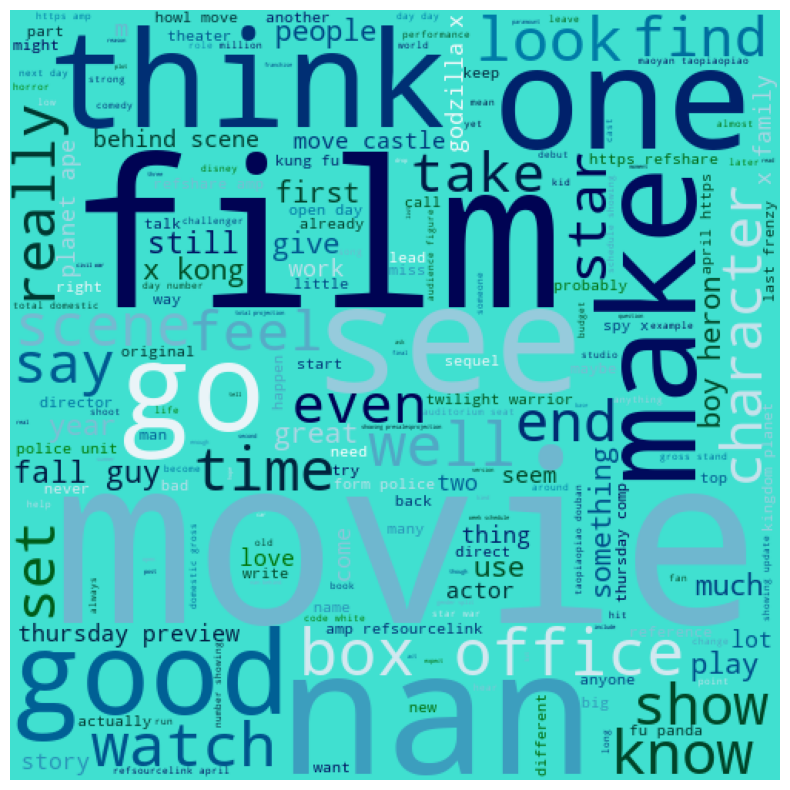

In [11]:
import wordcloud
from wordcloud import WordCloud

#combine all the articles
text_data = ""
for text in data.text:
    text_data = text_data+" "+text

#ploting the word cloud
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width = 500, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(text_data)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
#tokenize articles
tokeize_article = data.text.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('ever', 1),
 ('film', 1),
 ('movie', 1),
 ('see', 1),
 ('short', 1),
 ('strange', 1)]

In [16]:
# build LDA model for 10 topic
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.3,
                                           per_word_topics=True,
                                           eta = 0.7)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"scene" + 0.071*"behind" + 0.015*"well" + 0.008*"play" + '
  '0.007*"right" + 0.006*"story" + 0.005*"model" + 0.005*"scenes" + '
  '0.005*"photo" + 0.004*"thing"'),
 (1,
  '0.017*"shoot" + 0.010*"win" + 0.007*"order" + 0.007*"result" + 0.006*"help" '
  '+ 0.006*"city" + 0.006*"we" + 0.005*"hope" + 0.004*"full" + '
  '0.004*"receive"'),
 (2,
  '0.037*"film" + 0.032*"movie" + 0.014*"make" + 0.012*"one" + 0.010*"see" + '
  '0.009*"also" + 0.008*"like" + 0.008*"year" + 0.008*"part" + 0.007*"time"'),
 (3,
  '0.027*"big" + 0.006*"de" + 0.006*"put" + 0.005*"dead" + 0.005*"friend" + '
  '0.005*"€" + 0.005*"black" + 0.005*"world" + 0.005*"series" + 0.004*"mr"'),
 (4,
  '0.025*"good" + 0.023*"look" + 0.021*"go" + 0.017*"show" + 0.014*"audience" '
  '+ 0.012*"around" + 0.011*"could" + 0.010*"april" + 0.009*"great" + '
  '0.009*"still"'),
 (5,
  '0.120*"nan" + 0.047*"set" + 0.011*"director" + 0.010*"\'" + 0.009*"star" + '
  '0.008*"amp" + 0.008*"photo" + 0.006*"john" + 0.006*"direct"

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.049992 -0.193806       1        1  29.834315
7      0.276039  0.101621       2        1  17.073325
5     -0.128251  0.154133       3        1   9.879501
4     -0.014449 -0.033786       4        1   7.519617
0     -0.068323  0.003003       5        1   6.399576
6     -0.002289 -0.005827       6        1   6.306296
8      0.005881  0.001708       7        1   6.124536
9     -0.035223 -0.001943       8        1   5.960963
3     -0.043839 -0.008746       9        1   5.945313
1     -0.039537 -0.016355      10        1   4.956558, topic_info=             Term         Freq        Total Category  logprob  loglift
108           nan  1887.000000  1887.000000  Default  30.0000  30.0000
464         scene   744.000000   744.000000  Default  29.0000  29.0000
1650       behind   731.000000   731.000000  Default  28.0000  28.0000
1            film  1780.000000  1780.000000  Default  27.0000  27.0000
312           set   770.000000   770.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2911        enter    15.566426    26.807604  Topic10  -6.2256   2.4609
1092       report    15.038787    23.649239  Topic10  -6.2601   2.5518
762   competition    17.742678    54.758557  Topic10  -6.0947   1.8775
158          make    25.789176   670.594139  Topic10  -5.7207  -0.2538
287        follow    16.929878   170.617519  Topic10  -6.1416   0.6941

[436 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
96         1  0.006263        '
96         3  0.970830        '
7927       1  0.013499  abigail
7927       2  0.917947  abigail
7927       3  0.013499  abigail
...      ...       ...      ...
12834      2  0.067230        €
12834      4  0.016808        €
12834      6  0.067230        €
12834      7  0.033615        €
12834      9  0.773148        €

[1454 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 6, 5, 1, 7, 9, 10, 4, 2])

In [66]:
# Compute Perplexity
print('\nPerplexity : ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -8.605820247338157

Coherence Score:  0.4697131144281214


In [67]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# n : 80 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5090465539850662
#list containing various hyperparameters
no_of_topics = [90,100,110,120,130,140,150,160,170,180,190,200]
alpha_list = [0.3]
beta_list = [0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 90 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5583198660819148
n : 100 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5604706703876211
n : 110 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6082021001229695
n : 120 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6334481107913892
n : 130 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5721154377661957
n : 140 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.5779316933781858
n : 150 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.6468075378934907


KeyboardInterrupt: 

In [68]:
n = 120
alpha = 0.3
beta = 0.7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6334481107913892


In [70]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

TypeError: Object of type complex128 is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster      Freq
topic                                                                   
99     0.024265+0.000000j  0.223813+0.000000j       1        1  7.228117
115    0.233803+0.000000j -0.049804+0.000000j       2        1  3.704097
39    -0.093808+0.000000j  0.030877+0.000000j       3        1  3.673691
59    -0.092517+0.000000j -0.107134+0.000000j       4        1  3.599332
93    -0.025387+0.000000j  0.012504+0.000000j       5        1  3.389695
...                   ...                 ...     ...      ...       ...
88    -0.000432+0.000000j -0.000458+0.000000j     116        1  0.605212
80    -0.000432+0.000000j -0.000458+0.000000j     117        1  0.605212
114   -0.000432+0.000000j -0.000458+0.000000j     118        1  0.605212
81    -0.000432+0.000000j -0.000458+0.000000j     119        1  0.605212
77    -0.000432+0.000000j -0.000458+0.000000j     120        1  0.605212

[120 rows x 5 colum